# Social Network Analysis
## To Do
- [ ] See list of columns and what sort of analysis you can do on it
- [ ] Research on SNA
- [ ] How to do it dynamically

## Analysis
- [ ] Transactions at the same merchant within a short time frame
- [ ] Bipartitie graphs for connections between cardholders and merchants
- [ ] Path Analysis : Use Breadth-First Search (BFS) or Depth-First Search (DFS) to uncover paths connecting individuals, potentially revealing fraud networks.
- [ ] Temporal Analysis : visualize how relationships evolve and detect sudden shifts
- [ ] Link Prediction : Anticipate future fraud based on existing patterns


In [521]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from networkx.algorithms.community import girvan_newman
from networkx.algorithms import bipartite
from community import community_louvain
from itertools import combinations

In [522]:
data = pd.read_csv("transactions.csv")

In [523]:
data.columns

Index(['customer_name', 'merchant_name', 'transaction_id', 'isFraud',
       'cc_num'],
      dtype='object')

# Fraud Graph

In [524]:
def basic_network(data, node_separation = 3, num_of_points = 10) -> tuple[nx.Graph, list]:
  """
  Performs social network analysis on a credit card fraud dataset, identifying clusters using Louvain Modularity
  and visualizes the network using NetworkX.

  Returns:
    The Graph

  Interpretation :
    The Nodes are the Person and the Merchant

    The red lines show fradulent transactions while blue shows the other way around
  """
  data = data.iloc[:num_of_points]
  G = nx.Graph()

  for index, row in data.iterrows():
      sender = row["customer_name"]
      receiver = row["merchant_name"]
      fraud_status = row["isFraud"]
      G.add_node(sender, type="sender")
      G.add_node(receiver, type="receiver")
      G.add_edge(sender, receiver, is_fraudulent=fraud_status)

  print("Graph created")

  pos = nx.spring_layout(G, k=node_separation)
  fraudulent_edges = [(u, v) for u, v, d in G.edges(data=True) if d["is_fraudulent"] == 1]
  non_fraudulent_edges = [(u, v) for u, v, d in G.edges(data=True) if d["is_fraudulent"] == 0]

  # Separate edges by fraud status
  nx.draw_networkx_edges(G, pos, edgelist=fraudulent_edges, edge_color='red', width=2)
  nx.draw_networkx_edges(G, pos, edgelist=non_fraudulent_edges, edge_color='blue', width=1)

  # Draw nodes
  sender_nodes = [node for node, attr in G.nodes(data=True) if attr["type"] == "sender"]
  receiver_nodes = [node for node, attr in G.nodes(data=True) if attr["type"] == "receiver"]

  nx.draw_networkx_nodes(G, pos, nodelist=sender_nodes, node_color='yellow', node_size=500)
  nx.draw_networkx_nodes(G, pos, nodelist=receiver_nodes, node_color='green', node_size=500)

  # Draw labels
  nx.draw_networkx_labels(G, pos)

  plt.title("Fraudulent vs Non-Fraudulent Transactions")
  plt.axis('off')
  plt.show()

  return G, fraudulent_edges

# Cluster Analysis

Louvain Modularity or Girvan-Newman to identify tightly knit groups of nodes

In [525]:
def analyze_fraud_network(df, num_of_points = 10) -> None:
  """
  Performs social network analysis on a credit card fraud dataset, identifying clusters using Louvain Modularity
  and visualizes the network using NetworkX.

  Returns:
    None

  Interpretation :
    Louvain Modularity: Aims to identify densely connected groups of nodes, suggesting potential communities or shared patterns.
    Girvan-Newman: Identifies edges that, when removed, would break the network into distinct clusters.

    TO DO : Look at common characteristics between clusters
    Focus on the central nodes in highly connected clusters
  """

  df = df.iloc[:num_of_points]

  # bipartite graph
  G = nx.Graph()
  G.add_nodes_from(df['merchant_name'].unique(), bipartite=0)
  G.add_nodes_from(df[['customer_name']].apply(tuple, axis=1).unique(), bipartite=1)

  for idx, row in df.iterrows():
    G.add_edge(row['merchant_name'], (row['customer_name']), is_fraudulent=row['isFraud'])

  G_projected = bipartite.projected_graph(G, nodes=[node for node, attrdict in G.nodes(data=True) if attrdict['bipartite'] == 1])

  # Cluster analysis using Louvain Modularity
  communities = community_louvain.best_partition(G_projected)

  # viz
  node_colors = [communities[node] for node in G_projected.nodes()]
  nx.draw(G_projected, with_labels=True, node_color=node_colors)
  plt.show()

# Subgraph Analysis + Centrality Measures
Centrality Measures : Identify incluencial actors (Metrics)

  - Many connections (degree centrality)
  - Control over information flow (betweenness centrality)
  - Quick access to others (closeness centrality)

In [526]:
def analyze_fraud_subgraph(G, fraudulent_edges):
    """
    Isolates the fraud subnetwork from the given graph and performs subgraph analysis.

    Args:
        G: OUTPUT OF THE basic_graph Function
        fraudulent_edges : List of Fradulent graph connections

    Returns:
        None

    Interpretations :
      Do it yourself, nerd
    """

    # Isolate the fraud subnetwork
    fraud_subgraph = G.edge_subgraph(fraudulent_edges)

    # Identify the connected components
    connected_components = list(nx.connected_components(fraud_subgraph))
    print("Number of connected components in fraud subgraph:", len(connected_components))

    # DEGREE CENTRALITY
    degree_centrality = nx.degree_centrality(fraud_subgraph)
    most_central_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:5]
    print("Top 5 most central nodes:", most_central_nodes)

    # BETWEENNESS CENTRALITY
    betweenness_centrality = nx.betweenness_centrality(fraud_subgraph)
    most_influential_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:5]
    print("Top 5 most influential nodes:", most_influential_nodes)

    # CLOSENESS CENTRALITY
    closeness_centrality = nx.closeness_centrality(fraud_subgraph)
    most_central_nodes_closeness = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:5]
    print("Top 5 most central nodes by closeness centrality:", most_central_nodes_closeness)

    clustering_coefficient = nx.average_clustering(fraud_subgraph)
    print("Clustering coefficient:", clustering_coefficient)

    plt.figure()
    pos = nx.spring_layout(fraud_subgraph)
    nx.draw(fraud_subgraph, pos, with_labels=True, node_color='lightblue', edge_color='red')
    plt.title("Fraud Subgraph")
    plt.show()

# Shared CC Numbers

In [527]:
def analyze_shared_cc_numbers(df):
   """
   Identify Shared CCs

   Args:
      df

   Returns:
       None
   """

   G = nx.Graph()
   for name, group in df.groupby(['customer_name']):
       G.add_node(name)

   # Connect nodes if they share a credit card number
   for cc_num, group in df.groupby('cc_num'):
       names = set(zip(group['customer_name']))
       if len(names) > 1:
           for name1, name2 in combinations(names, 2):
               G.add_edge(name1, name2)

   nx.draw(G, with_labels=True, font_weight='bold')
   plt.title("Shared Credit Card Number Network")
   plt.show()

   # Calculate network metrics
   degree_centrality = nx.degree_centrality(G)
   betweenness_centrality = nx.betweenness_centrality(G)

   print("Degree Centrality:")
   print(degree_centrality)

   print("\nBetweenness Centrality:")
   print(betweenness_centrality)

   # Identify highly connected individuals
   most_connected_individuals = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
   print("\nMost Connected Individuals:")
   print(most_connected_individuals)

# Functions Testing

Graph created


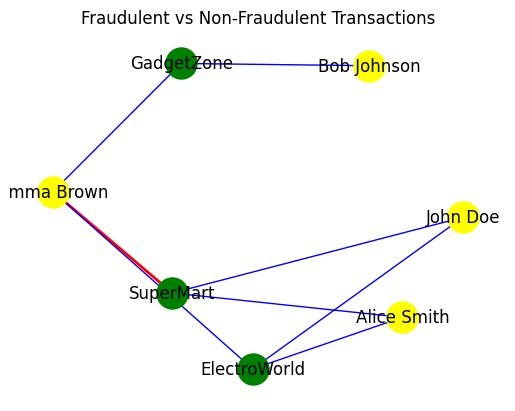

In [528]:
G, fraudulent_edges = basic_network(data, node_separation = 3, num_of_points = 40)

Number of connected components in fraud subgraph: 1
Top 5 most central nodes: ['Emma Brown', 'SuperMart']
Top 5 most influential nodes: ['Emma Brown', 'SuperMart']
Top 5 most central nodes by closeness centrality: ['Emma Brown', 'SuperMart']
Clustering coefficient: 0.0


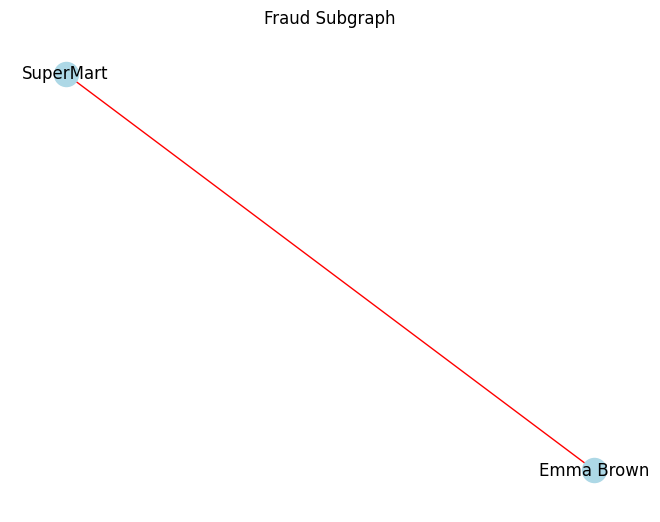

In [529]:
analyze_fraud_subgraph(G, fraudulent_edges)

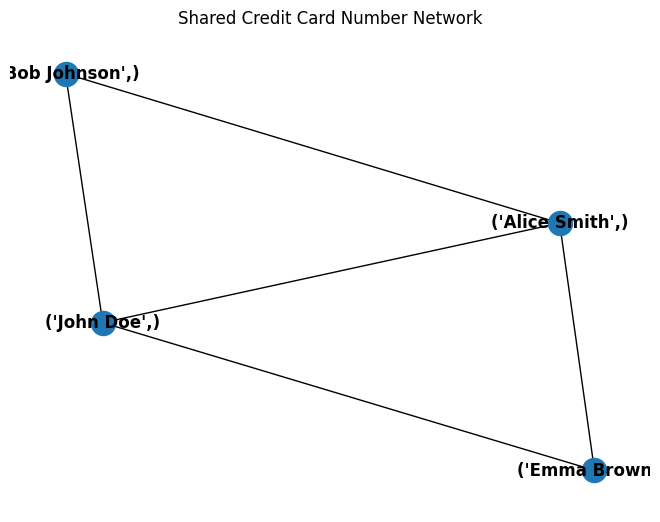

Degree Centrality:
{('Alice Smith',): 1.0, ('Bob Johnson',): 0.6666666666666666, ('Emma Brown',): 0.6666666666666666, ('John Doe',): 1.0}

Betweenness Centrality:
{('Alice Smith',): 0.16666666666666666, ('Bob Johnson',): 0.0, ('Emma Brown',): 0.0, ('John Doe',): 0.16666666666666666}

Most Connected Individuals:
[(('Alice Smith',), 1.0), (('John Doe',), 1.0), (('Bob Johnson',), 0.6666666666666666), (('Emma Brown',), 0.6666666666666666)]


In [530]:
analyze_shared_cc_numbers(data)